In [150]:
from ucimlrepo import fetch_ucirepo
import pandas as pd
from sklearn.preprocessing import StandardScaler
import umap
import matplotlib.pyplot as plt


In [151]:
# 1️⃣ Tải dữ liệu
data = fetch_ucirepo(id=544)




In [173]:
# Gộp X và y để tiện xử lý
X = data.data.features
y = data.data.targets
df = pd.concat([X, y], axis=1)

# 2️⃣ Lọc theo nhãn mong muốn
# selected_labels = ["Insufficient_Weight", "Normal_Weight", "Overweight_Level_II", "Obesity_Type_II"]
selected_labels = ["Normal_Weight","Overweight_Level_II", "Obesity_Type_I",]
df = df[df['NObeyesdad'].isin(selected_labels)]

# 3️⃣ Tách theo giới tính
df_source = df[df['Gender'] == 'Male']
df_target = df[df['Gender'] == 'Female']
# Bỏ cột không dùng
drop_cols = ['Gender', 'NObeyesdad']
X_source = df_source.drop(columns=drop_cols)
X_target = df_target.drop(columns=drop_cols)
y_source = df_source['NObeyesdad']
y_target = df_target['NObeyesdad']

In [174]:
print("source", y_source.value_counts())
print("target", y_target.value_counts())

source NObeyesdad
Obesity_Type_I         195
Overweight_Level_II    187
Normal_Weight          146
Name: count, dtype: int64
target NObeyesdad
Obesity_Type_I         156
Normal_Weight          141
Overweight_Level_II    103
Name: count, dtype: int64


In [175]:

# 4️⃣ Mã hóa các biến phân loại (one-hot)
X_source = pd.get_dummies(X_source, drop_first=True)
X_target = pd.get_dummies(X_target, drop_first=True)

# Căn chỉnh cột để giống nhau giữa 2 dataset
X_source, X_target = X_source.align(X_target, join='inner', axis=1)


In [176]:
# 5️⃣ Chuẩn hóa dữ liệu
scaler = StandardScaler()
X_source_scaled = scaler.fit_transform(X_source)
X_target_scaled = scaler.transform(X_target)


In [177]:

# 6️⃣ Giảm chiều bằng UMAP
reducer = umap.UMAP(random_state=42)
X_source_umap = reducer.fit_transform(X_source_scaled)
X_target_umap = reducer.fit_transform(X_target_scaled)

c:\Users\Asus\anaconda3\envs\dann\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


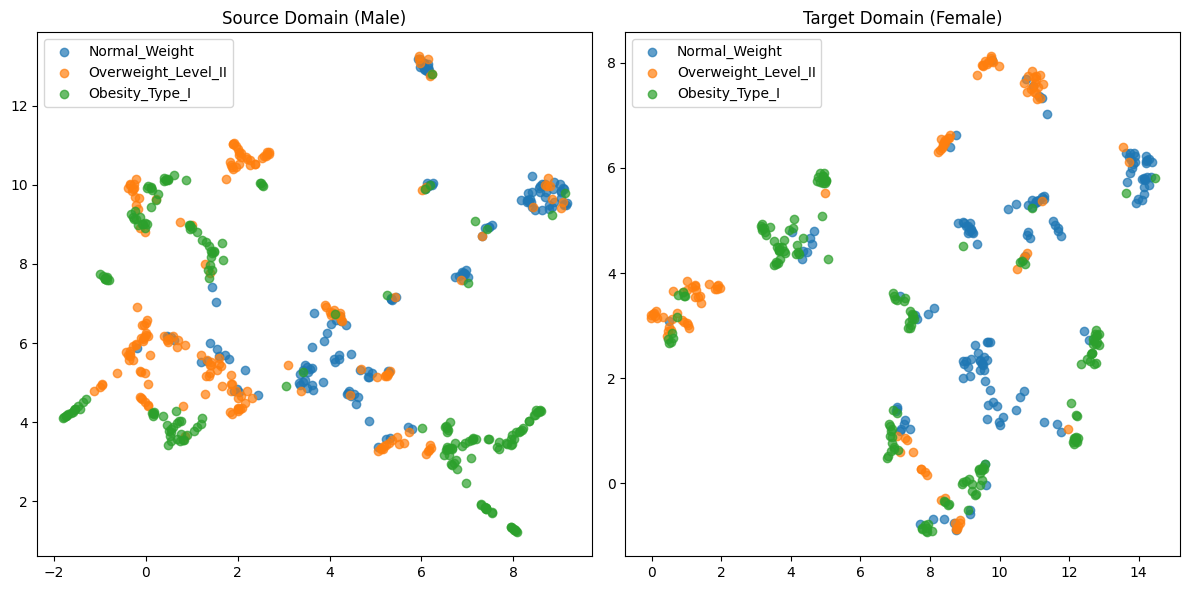

In [178]:


# 7️⃣ Vẽ biểu đồ
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot source (Male)
for label in selected_labels:
    mask = y_source == label
    axes[0].scatter(X_source_umap[mask, 0], X_source_umap[mask, 1], label=label, alpha=0.7)
axes[0].set_title("Source Domain (Male)")
axes[0].legend()

# Plot target (Female)
for label in selected_labels:
    mask = y_target == label
    axes[1].scatter(X_target_umap[mask, 0], X_target_umap[mask, 1], label=label, alpha=0.7)
axes[1].set_title("Target Domain (Female)")
axes[1].legend()

plt.tight_layout()
plt.show()


In [179]:
import os
import time
import yaml
import numpy as np
import torch
from torch.utils.data import TensorDataset
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, silhouette_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

import umap
from sklearn.manifold import TSNE
import pandas as pd
from models.wdgrl import WDGRL

In [180]:
X_s = X_source_scaled
X_t = X_target_scaled
ns, nt = X_s.shape[0], X_t.shape[0]
d = X_s.shape[1]
d

20

In [181]:
xs = torch.from_numpy(X_s).double()
xt = torch.from_numpy(X_t).double()

source_dataset = TensorDataset(xs)
target_dataset = TensorDataset(xt)


In [182]:
# ==== WDGRL model ====
final_model = WDGRL(
    input_dim=d,
    encoder_hidden_dims=[200,100],
    critic_hidden_dims=[100],
    alpha1=0.0001,
    alpha2=0.00001,
    seed=42,
)

# ==== Logging setup ====
timestamp = time.strftime("%Y%m%d-%H%M%S")+'-mnist-usps'
log_dir = os.path.join("logs", timestamp)
os.makedirs(log_dir, exist_ok=True)

log_file = os.path.join(log_dir, "results.txt")
log_loss = final_model.train(
    source_dataset,
    target_dataset,
    num_epochs=3000,
    gamma=4,
    dc_iter=6,
    batch_size=32,
    # early_stopping=True,
    model_path=log_dir,
)

final_model.save_model(log_dir)

# ==== Save logs ====
total_loss = log_loss["loss"]

Epoch: 100%|██████████| 3000/3000 [00:52<00:00, 57.08it/s]

Encoder and Critic saved to logs\20251111-114325-mnist-usps


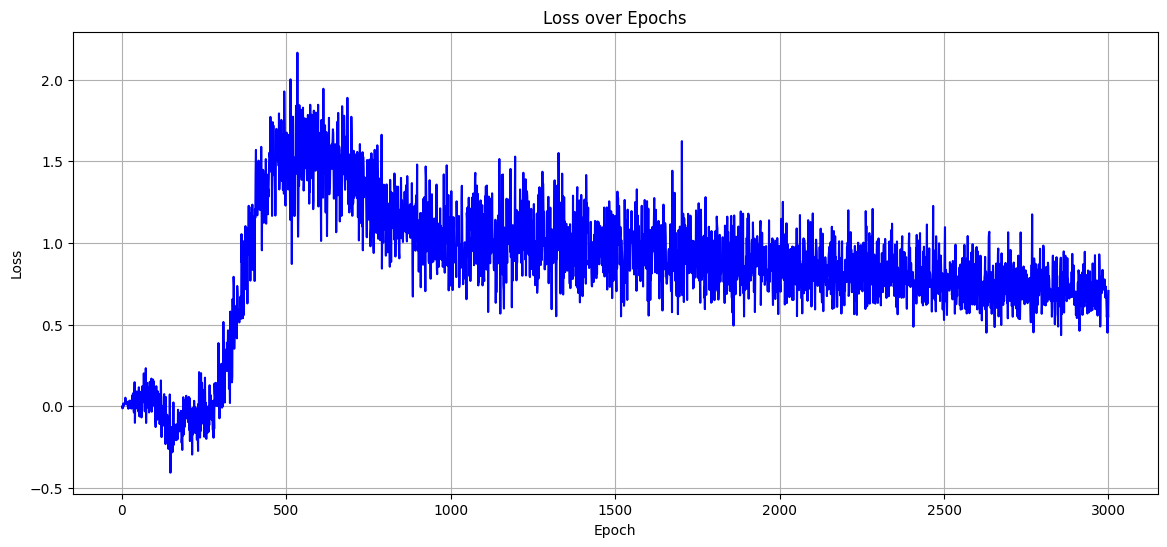

In [183]:
epochs = range(1, len(total_loss) + 1)

plt.figure(figsize=(14, 6))
plt.plot(epochs, total_loss, linestyle='-', color='blue')
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
# plt.ylim(0, 1.0)
plt.grid(True)
plt.savefig(os.path.join(log_dir, "loss.png"))
plt.show()
plt.close()

In [184]:
xs_hat = final_model.extract_feature(xs.cuda())
xt_hat = final_model.extract_feature(xt.cuda())
xs_hat = xs_hat.cpu().numpy()
xt_hat = xt_hat.cpu().numpy()

In [185]:
from sklearn.preprocessing import LabelEncoder

UMAP shape: (400, 2)


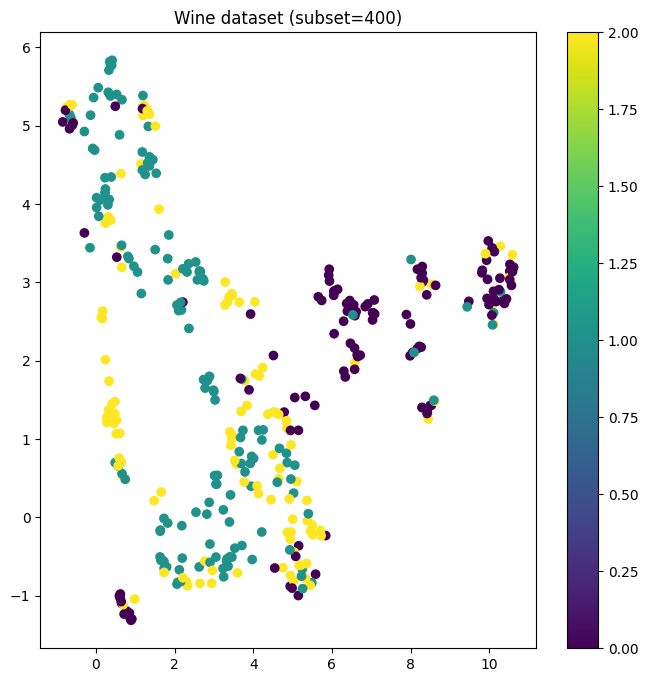

In [186]:
# Stack features and use the correct label arrays (source = y_train, target = y_usps_train)
X_all = np.vstack([xs_hat, xt_hat])
y_all = np.concatenate([y_source, y_target])

# Create domain labels (0=source, 1=target)
domain_all = np.concatenate([
    np.zeros(len(xs_hat), dtype=int),
    np.ones(len(xt_hat), dtype=int)
])

# sample subset for faster t-SNE (sample consistently from X, y and domain)
num_samples = 400
indices = np.random.choice(X_all.shape[0], num_samples, replace=False)

X_sub = X_all[indices]
y_sub = y_all[indices]
domain_sub = domain_all[indices]
le = LabelEncoder()
y_sub_encoded = le.fit_transform(y_sub)
# ✅ UMAP
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric="euclidean")
X_umap = reducer.fit_transform(X_sub)

print("UMAP shape:", X_umap.shape)

# ✅ plot``
plt.figure(figsize=(8,8))
scatter = plt.scatter(X_umap[:, 0], X_umap[:, 1], c=y_sub_encoded)
plt.colorbar(scatter)
plt.title(f"Wine dataset (subset={num_samples})")
plt.show()

In [187]:
print("Class mapping:", list(le.classes_))

Class mapping: ['Normal_Weight', 'Obesity_Type_I', 'Overweight_Level_II']
